# Statistical Learnning Model 

**Goals:**
 - Apply active learning
 - Quickly check the data using samples of maching learning models
 - Grasp some insights on the data
 - Data clearning
 - Add more the title feature
 
 
**More details on Active learning**: it may help if we have a short budget or not time to collect more data. 

The active learningf we select videos in which the likelihood is high and they may boost the model.


Use the the target labels to fit the first model - base model.

Import libraries

In [1]:
#!conda update scikit-learn

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# from sklearn.feature_extraction import TfidfVectorizer ===> gets an error
# pls use the import below
from sklearn.feature_extraction.text import TfidfVectorizer 

from scipy.sparse import hstack, vstack                            # used on bow of workds, vetoctored the 'Title' column

from sklearn.metrics import roc_auc_score, average_precision_score


%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\danie\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\danie\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


## Load raw data with labels

In [3]:
df = pd.read_csv('./raw_data/raw_data_with_labels.csv', index_col=0)

# select only data with labels
df = df[df['y'].notnull()]
print('Num of labelled data: ', df.shape)

Num of labelled data:  (527, 4)


In [4]:
df.head()
df.tail()

,title,y,upload_date,view_count
1300,"ML Bootcamp - Decision Tree, Random Forest & E...",0.0,20200804,2164
1301,Kaggle 3 Free Certificates | Python | Machine ...,0.0,20200802,3227
1302,Kaggle 101: Learn & Earn (Introduction),0.0,20200731,193
1303,#3 - Learn Python with Kaggle - Booleans and C...,0.0,20200731,445
1304,Pytorch Tutorial 5-Live- Kaggle Advance House ...,1.0,20200730,9441


# 1. Data Cleanup

Using a NEW dataframe with data that's ready and clean the data to fit the ML model.

In [5]:
# create a clean dataframe with the same indice on the original dataframe - raw data
df_clean = pd.DataFrame(index=df.index)

In [6]:
df_clean['date'] = pd.to_datetime(df['upload_date'], format='%Y%m%d')

# note: format='%Y %m %d' shows the time; format='%Y%m%d' brings only YYYY-MM-DD - easy!

In [7]:
df_clean['date']

# dtype: datetime64[ns] used by numpy and pandas

0      2021-05-05
1      2021-05-05
2      2021-05-05
3      2021-05-05
4      2021-05-05
          ...    
1300   2020-08-04
1301   2020-08-02
1302   2020-07-31
1303   2020-07-31
1304   2020-07-30
Name: date, Length: 527, dtype: datetime64[ns]

In [8]:
# columns views: make sure all NAN will be convert to 0 and an integer data type will be added
df_clean['views'] = df['view_count'].fillna(0).astype(int)

In [9]:
# adding title column. It will be used on the model....will be vectorized later

df_clean['title'] = df['title']

In [10]:
df_clean.dtypes

date     datetime64[ns]
views             int32
title            object
dtype: object

## 2.Features & Labels

Create an unique features dataframe. JUST an extra step. Making sure the features are ready.

**Reason**: Align the feaatures dataframe with the most cleaning data - raw data collected & cleaned. The cleaning process can skip rows or columns.


In [11]:
# features: it's similar to df_clean, just an extra step
features = pd.DataFrame(index=df_clean.index)

# labels/targets
y = df['y'].copy()

In [12]:
print('Features shape: {}'.format(shape(features)))
print('Labels shape: {}'.format(shape(y)))

Features shape: (527, 0)
Labels shape: (527,)


## Important: sklearn can't use *date* as a feature.

Let's manipulate and create a feature using the raw date - **Num_views_per_day**.

Sklearn needs a number.

In [13]:
# time_since_pub: time since the video was published. Random data choose. Use the date I created this code: fix date point - 2021-05-09

# np.timedelta64(1, 'D'): time delta in numpy. Difference in days
# we have data on a granually day, meaning a difference less than a day makes sense.
features['time_since_pub'] = (pd.to_datetime("2021-05-09") - df_clean['date']) / np.timedelta64(1, 'D')

# used features
features['views'] = df_clean['views']
features['views_per_day'] = features['views'] / features['time_since_pub']

features = features.drop(['time_since_pub'], axis=1)   # time_since_pub only used for the calculation

# time_since_pub as a feature may impact the model once the numbers seem to increase a lot and the end of the time serie.
# The training&validations datasets may not have a normal distributed values.Thus, an umbalaced feature weights
# and random samples are important to train and fit a ml model


In [14]:
features.head()
features.tail()

,views,views_per_day
1300,2164,7.784173
1301,3227,11.525000
1302,193,0.684397
1303,445,1.578014
1304,9441,33.360424


In [15]:
### not working on my personal computer###
# error: from_bounds() argument after * must be an iterable, not float

# TODO: update packages
#df_clean['date'].value_counts().plot(figsize=(20.10))

features.describe()

,views,views_per_day
count,5.270000e+02,527.000000
mean,1.598783e+04,308.274453
std,8.183696e+04,1154.782875
min,0.000000e+00,0.000000
25%,1.750000e+02,3.082796
50%,1.151000e+03,24.500000
75%,6.595500e+03,170.016129
max,1.472872e+06,17745.445783


## 3. Data Preparation

Let's try to split the train&validation datasets 50/50.

How the 2 features **view** and **views_per_day** impacted the ML model? 
Does a simple model with only 2 features impact the way the YouTube videos will be selected?

In [16]:
# check all data on df_clean
# pd.set_option('display.max_rows', 527)
# df_clean

median_date = df_clean['date'].quantile(0.5, interpolation="midpoint")
median_date

Timestamp('2021-03-12 00:00:00')

In [17]:
# splitting features dataset - trying a 50/50 using a median date
# balanced dataset is important!!!
# coed below can also be used
# Xtrain, Xval = features[df_clean['date'] < '2021-03-12'], features[df_clean['date'] >= '2021-03-12']
# ytrain, yval = y[df_clean['date'] < '2021-03-12 '], y[df_clean['date'] >= '2021-03-12 ']

# needed approach - mask parameter to select the data
mask_train = df_clean['date'] < '2021-03-12'
mask_val = df_clean['date'] >= '2021-03-12'

Xtrain, Xval = features[mask_train], features[mask_val]
ytrain, yval = y[mask_train], y[mask_val]

Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((263, 2), (264, 2), (263,), (264,))

## Add the title feature

**Important**: transforming the Title string to numbers.

Building a matrix in which each column will be the counting word from the Title feature.

Import to notice that commom words like machine+learning will have a low weight.



In [18]:
title_train = df_clean[mask_train]['title']
title_val = df_clean[mask_val]['title']

# Vectorizing the Title features
title_vec = TfidfVectorizer(min_df=2)   # object defined; mind_df = 2 means the minimum numnber of words that be used to create a column

# bow: bag of words
title_bow_train = title_vec.fit_transform(title_train)     # fit + transform: store the words on the features, plus how many times the word appeared
title_bow_val = title_vec.transform(title_val)             # validation set ONLY transform. Validation should NOT learning the words

In [19]:
# checking
title_bow_train.shape
title_bow_train

<263x241 sparse matrix of type '<class 'numpy.float64'>'
	with 1659 stored elements in Compressed Sparse Row format>

 TfidfVectorizer function returns a vectorized sparse matrix. It's an optimize matrix in Scipy where only values NOT equal to zero are returned.

In [20]:
# the sparse matrix 'title_bow_train' contains 1659 elements NOT ZERO
1 - 1659/(263*241)   # % of ZERO elements on the sparse matrix, but only 3% are NOT ZERO elements. Meaning that the matrix is sparse computationally and mathematically speaking

0.9738257892494833

In [21]:
Xtrain.head()

# train dataset so far. But, now the 'Title' will be added to train&validation

,views,views_per_day
133,243272,4123.254237
134,180,2.903226
135,196,3.062500
136,24828,381.969231
137,23338,353.606061


## IMPORTANT to note: 
Combining simple matrix - Xtrain&Xval - with a sparse matrix - title_bow_train&title_bow_val

Use scipy.sparse hstack and vstack

More details on hstack and vstack...stacking matrix (vectoes) horizontally and vertically

Sample:

hstack - [1 2]    [3 4]  -> [1 2 3 4]

vstack [1 2]      [3 4]  -> [1 2]
                            [3 4]
                            
USE *scipy.sparse hstack and vstack*, numpy sparse function may take TOO LONG, or not compute at all!!

In [22]:
# combining sparse matrix with original features
from scipy.sparse import hstack, vstack  

Xtrain_wtitle = hstack([Xtrain, title_bow_train])
Xval_wtitle = hstack([Xval, title_bow_val])

In [24]:
Xtrain_wtitle.shape, Xval_wtitle.shape

# 2 nummerical features on training dataset plus 241 columns from 'Title'

<263x243 sparse matrix of type '<class 'numpy.float64'>'
	with 2183 stored elements in COOrdinate format>

## Random Forest

In [25]:
# check number of 1 samples under train dataset
print('Positive samples - videos select: {}'.format(ytrain.mean() * 263))
print(' % of positive samples - videos select: {}'.format(ytrain.mean() * 100))

# definitely unbalaced

Positive samples - videos select: 104.0
 % of positive samples - videos select: 39.543726235741445


The training dataset is not big!!

In [26]:
clf_rf = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced', n_jobs=6)    # defined object

## Fitting the model against the train dataset

NOW: 3 features - views, views per day, and title

In [27]:
clf_rf.fit(Xtrain_wtitle, ytrain)

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\danie\Anaconda3\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=6, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [28]:
print('ML model already trainded/fitted and ready to be used!')

ML model already trainded/fitted and ready to be used!


## Predicting if a video has been select

Probability = 1

predict_proba: returns a numpy array with prob of zero and prob of 1

In [29]:
pred = clf_rf.predict_proba(Xval_wtitle)[:, 1]   # only 1

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


## Metrics - validating the model


In [30]:
# area of precision for decision tree

print('Random Forest Model')
average_precision_score(yval, pred)

Random Forest Model


0.4566659359075169

## IMPORTANT: any future model in PRD should have a greater than baseline model **0.49**

In [31]:
# area under curve of roc curve metric
roc_auc_score(yval, pred)

0.5182456140350877

## Random Forest gets a better result


NameError: name 'plot_tree' is not defined

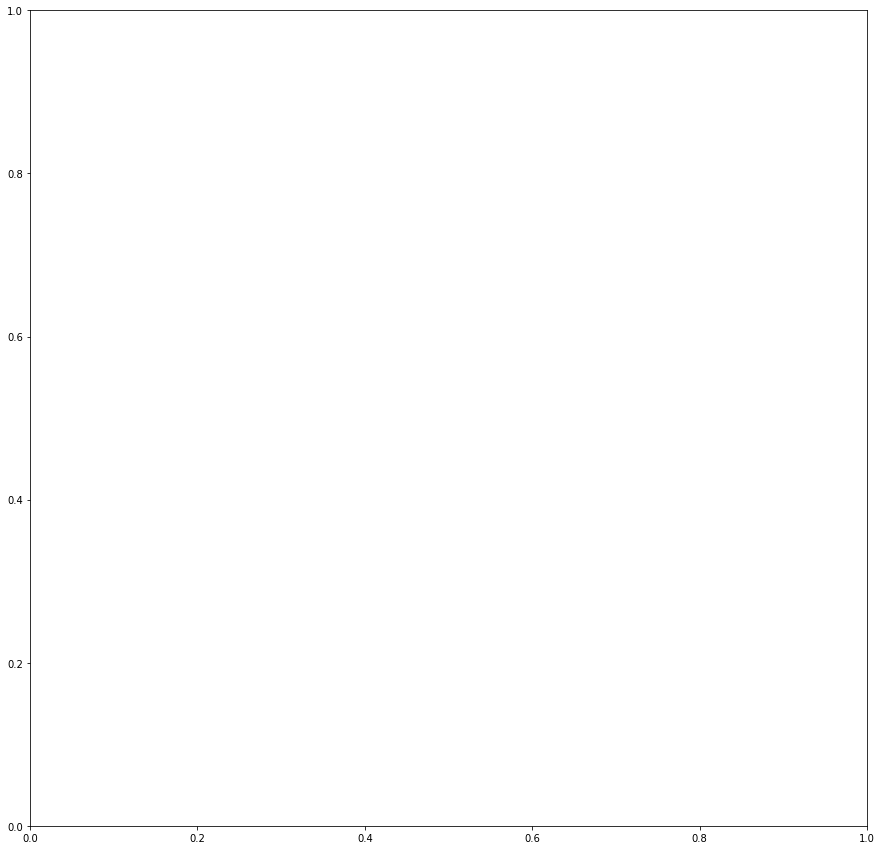

In [32]:
fig, ax = pylab.subplots(1,1, figsize=(15,15))
plot_tree(clf_dt, ax=ax, feature_names=Xtrain.columns)

## Quick glance of the machine learning model

The Random Forest statistical model seems to have better metrics (average precison & roc curve) than the baseline model.

**Baseline Model**

ap = 0.42

auc = 0.49

**Random Forest Model**

ap = 0.45

auc = 0.51